### UnlockPickUp Environment (Not Continual)

Doing this for a simple implementation before continual, and before BabyAI (text input)

**Imports**

In [1]:
import gymnasium as gym
import minigrid
import math
import random
import time
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [4]:
# Make the miniGrid environment
# env = gym.make('MiniGrid-UnlockPickup-v0')
env = gym.make('MiniGrid-Empty-5x5-v0') # Learns this easily
# env = gym.make('MiniGrid-DoorKey-5x5-v0')

# Print out the number of Discrete actions available (output variables)
print(f'Action Space: {env.action_space}')

# Print out observation space (input variables)
print(f'Observation Space: {env.observation_space}')

Action Space: Discrete(7)
Observation Space: Dict('direction': Discrete(4), 'image': Box(0, 255, (7, 7, 3), uint8), 'mission': MissionSpace(<function EmptyEnv._gen_mission at 0x000002173AE42050>, None))


In [5]:
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)

print(f'Selected Device: {device}')

Selected Device: cuda


#### Replay Memory Buffer

Stores past 'Transition' states of up to 10,000 (play around with this) of the latest experiences 

In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        # Creates a deque object storing type array with a capacity
        # Once capacity is reached, old experiences will automatically be overwriteen with the new
        self.memory = deque([], maxlen=capacity)

    # Save the transition to the memory
    def push(self, *args):
        self.memory.append(Transition(*args))

    # Return batch_size samples for use in optimization 
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [7]:
# Import the custom NN model
from DQN import UnlockPickUpDQN

#### Pre-Training Setup

Defining variables and creating networks (policy and target) that will be used in training 

In [8]:
BATCH_SIZE = 128
GAMMA = 0.99 # Discount factor on future states

# Epsilon-greedy variables needed
EPS_START = 0.9 # Start off encouraging the model to explore
EPS_END = 0.05 # After exploring, the model will stabilize and rarely explore
EPS_DECAY = 1000 # Rate at which the epsilon threshold will decrease (exponent)

TAU = 0.005 # Rate at which the target network will be updated
LR = 1e-4 # Learning rate of the policy net

# Store number of possible actions the model can take (7)
n_actions = env.action_space.n

state, _ = env.reset()

# Number of inputs to the model. In this case there are 3 as shown above
n_observations = len(state)

print(n_actions)
# Increase for a more complex network
hidden_dim = 256

# Create the policy and target network
policy_network = UnlockPickUpDQN(n_actions, hidden_dim)
target_network = UnlockPickUpDQN(n_actions, hidden_dim)

# Initialize the target_network to be the same as policy (this is cruicial)
target_network.load_state_dict(policy_network.state_dict())

# Send models to device
policy_network.to(device)
target_network.to(device)

optimizer = optim.AdamW(policy_network.parameters(), lr=LR, amsgrad=True)

# Customize capacity for bigger nets
memory = ReplayMemory(10_000)

7


#### Epsilon-Greedy Select Function

In [9]:
steps_done = 0

def select_action(state):
    global steps_done

    # Generate the random number for epsilon greedy selection
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)

    # Greedy action selection takes place here
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # PAss the state through the model without gradient descent (we're not learning here, just need an action)
            # Select the max Q-Value (action) the model chose and return the reshaped index of said action
            return policy_network(state).max(1).indices.view(1, 1)
    else:
        # If random action is selected, choose a random action from env, and send to device
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)    


#### Plotting Definitions

In [10]:
episode_durations = []
episode_rewards = []

# def plot_durations(show_result=False):
#     plt.figure(1)
#     durations_t = torch.tensor(episode_durations, dtype=torch.float)
#     if show_result:
#         plt.title('Result')
#     else:
#         plt.clf() # Clear current figure
#         plt.title('Training...')

#     plt.xlabel('Episode')
#     plt.ylabel('Duration')
#     plt.plot(durations_t.numpy())

#     # Additionally, start plotting the mean after 100 episodes
#     if len(durations_t) >= 100:
#         means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
#         means = torch.cat((torch.zeros(99), means))
#         plt.plot(means.numpy())

#     plt.pause(0.001)
#     if is_ipython:
#         if not show_result:
#             display.display(plt.gcf())
#             display.clear_output(wait=True)
#         else:
#             display.display(plt.gcf())

def plot_durations(show_result=False):
    plt.figure(1)
    plt.clf()
    
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)

    plt.subplot(2, 1, 1)
    plt.title('Episode Duration')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.subplot(2, 1, 2)
    plt.title('Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy())
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.tight_layout()
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


#### Model Optimization

Where the learning of the policy network occurs

In [11]:
def optimize_model():
    
    # Build up the memory first
    if len(memory) < BATCH_SIZE:
        return
    
    # Select a batch of memories to learn from
    transitions = memory.sample(BATCH_SIZE)

    # Reshape array of tuple Transitions into array of tensor transitions
    # Combine into a single Transition capable of being batch processed
    # I don't really get this line. Just reshapes and redefines
    batch = Transition(*zip(*transitions))

    non_terminal_mask = torch.tensor(
        # For every state, if it's not terminal, return the next_state
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool
    )

    # Extract all non-terminal next_states from the current batch
    non_terminal_next_states = torch.cat([s for s in batch.next_state if s is not None])

    # Store the state, action, and reward of each item in the batch
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Select the corrosponding index of the actual action taken to get the Q-Value for that action
    state_action_values = policy_network(state_batch).gather(1, action_batch)

    next_states_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # Get what action the target_network would have taken in this position
        # Only in states that don't terminate
        next_states_values[non_terminal_mask] = target_network(non_terminal_next_states).max(1).values

    # Calculate the bellman equation for usage in the loss calculation
    expected_state_action_values = (next_states_values * GAMMA) + reward_batch

    # Calculate the loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_network.parameters(), 100)
    optimizer.step()

#### Training Loop

Complete


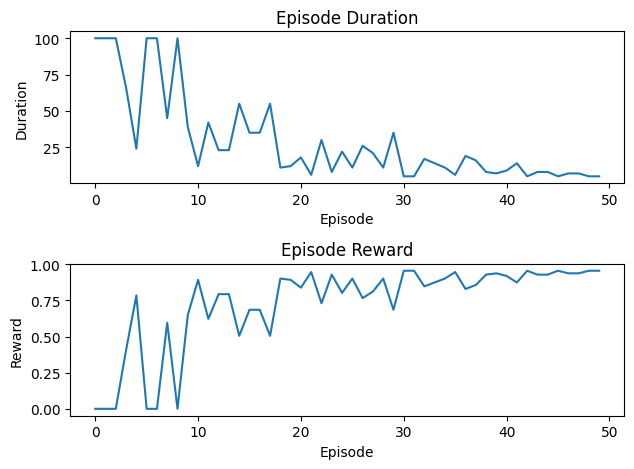

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

print(f'Training for {num_episodes} episodes...')
for i_episode in range(num_episodes):

    obs, _ = env.reset()
    # permute(2, 0, 1) re-orders the image from (height, width, color) -> (color, height, width)
    # adding .unsqueeze(0) adds the extra batch dimension to result in a (1, color, height, width)
    state = torch.tensor(obs['image'], dtype=torch.float32, device=device).permute(2, 0, 1).unsqueeze(0)

    total_reward = 0
    for t in count(1):
        # Select e-greedy action
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        # Update the next_state with the next observationo unless it's terminated
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation['image'], dtype=torch.float32, device=device).permute(2, 0, 1).unsqueeze(0)

        # Send experience to memory
        memory.push(state, action, next_state, reward)
        state = next_state

        # Trigger the policy network to train
        optimize_model()

        # Soft update of the target network based on the current weights of policy_network
        target_net_state_dict = target_network.state_dict()
        policy_net_state_dict = policy_network.state_dict()

        # Take the weights of the current target net and nudge them toward the policy net very slowly
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU \
                + target_net_state_dict[key] * (1 - TAU)
        
        target_network.load_state_dict(target_net_state_dict)

        total_reward += reward.item()

        if done:
            episode_durations.append(t)
            episode_rewards.append(total_reward)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [13]:
torch.save(policy_network.state_dict(), './models/policy_model.pt')